In [2]:

import numpy as np
import matplotlib.pyplot as plt

In [3]:
def f_true(x):
    return 0.03 * x ** 4 - 0.4 * x ** 2 + 0.7 * np.sin(2.2 * x)

def make_poly_features(x, degree):
    x = np.asarray(x).reshape(-1, 1)
    X = np.hstack([x ** i for i in range(degree + 1)])
    return X

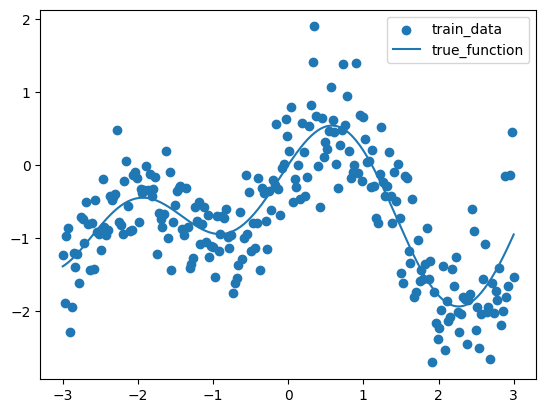

In [4]:
rng = np.random.default_rng(42)

N = 250
x = np.linspace(-3, 3, N)

sigma = 0.5
y = f_true(x) + rng.normal(0, sigma, size=x.shape)

degree = 15
X = make_poly_features(x, degree)

plt.scatter(x, y, label='train_data')
plt.plot(x, f_true(x), label='true_function')
plt.legend()
plt.show()

In [5]:
lamb = 1.0
alpha = 1.0 / (sigma ** 2)

M = X.shape[1]
posterior_cov_inv = lamb * np.eye(M) + alpha * (X.T @ X)

In [6]:
posterior_cov = np.linalg.inv(posterior_cov_inv)
mean = alpha * posterior_cov @ (X.T @ y)

In [7]:
x_new = np.linspace(-3, 3, 400)
X_new = make_poly_features(x_new, degree)

mean_pred = X_new @ mean
var_pred = 1.0 / alpha + np.sum(X_new @ posterior_cov @ X_new.T, axis=1)
std_pred = np.sqrt(var_pred)

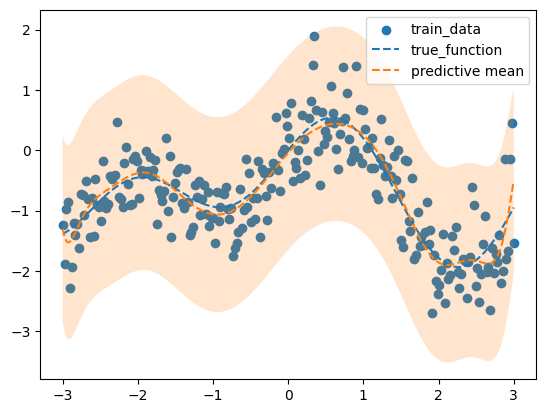

In [8]:
plt.scatter(x, y, label='train_data')
plt.plot(x_new, f_true(x_new), linestyle='--', label='true_function')
plt.plot(x_new, mean_pred, linestyle='--', label='predictive mean')

plt.fill_between(x_new, mean_pred - 2 * std_pred, mean_pred + 2 * std_pred, alpha=0.2)

plt.legend()
plt.show()

In [9]:
def log_evidence(lamb, X, y, alpha):
    sigma2 = 1.0 / alpha
    N = X.shape[0]

    C = sigma2 * np.eye(N) + (sigma2 / lamb) * (X @ X.T)

    try:
        L = np.linalg.cholesky(C + 1e-8 * np.eye(N))
        logdetC = 2.0 * np.sum(np.log(np.diag(L)))

        z = np.linalg.solve(L, y)
        sol = np.linalg.solve(L.T, z)
        quad_form = y @ sol

        logev = -0.5 * (N * np.log(2*np.pi) + logdetC + quad_form)
        return float(logev)
    except np.linalg.LinAlgError:
        return -np.inf


Оптимальная λ = 3.231721758481958


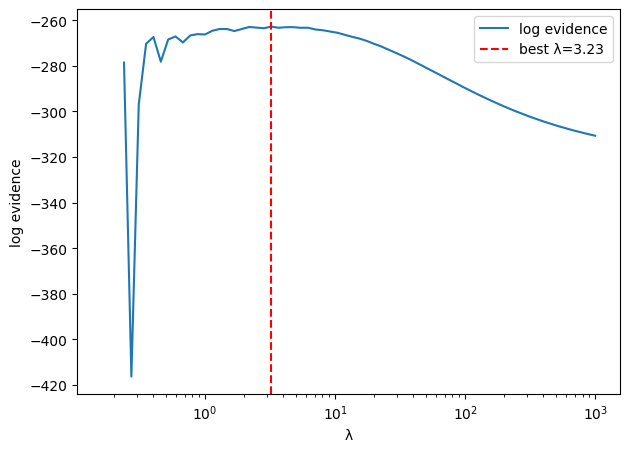

In [10]:
lamb_grid = np.logspace(-6, 3, 160)
logev_values = [log_evidence(l, X, y, alpha) for l in lamb_grid]

best_idx = int(np.argmax(logev_values))
best_lambda = lamb_grid[best_idx]
print("Оптимальная λ =", best_lambda)

plt.figure(figsize=(7,5))
plt.semilogx(lamb_grid, logev_values, label="log evidence")
plt.axvline(best_lambda, color='r', linestyle='--', label=f"best λ={best_lambda:.3g}")
plt.xlabel("λ")
plt.ylabel("log evidence")
plt.legend()
plt.show()


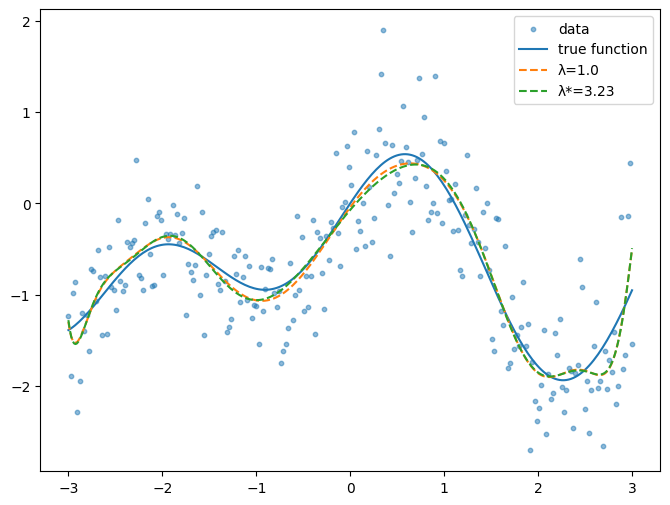

In [11]:
def fit_posterior_mean(X, y, alpha, lamb):
    M = X.shape[1]
    A = lamb * np.eye(M) + alpha * (X.T @ X)
    posterior_cov = np.linalg.inv(A)
    mean = alpha * posterior_cov @ (X.T @ y)
    return mean

# обучаем при разных λ
mean_base = fit_posterior_mean(X, y, alpha, 1.0)
mean_best = fit_posterior_mean(X, y, alpha, best_lambda)

# предсказания
x_new = np.linspace(-3, 3, 400)
X_new = make_poly_features(x_new, degree)
y_pred_base = X_new @ mean_base
y_pred_best = X_new @ mean_best

# графики
plt.figure(figsize=(8,6))
plt.scatter(x, y, s=10, alpha=0.5, label="data")
plt.plot(x, f_true(x), label="true function")
plt.plot(x_new, y_pred_base, '--', label="λ=1.0")
plt.plot(x_new, y_pred_best, '--', label=f"λ*={best_lambda:.3g}")
plt.legend()
plt.show()
